# 多層パーセプトロン回帰（MLP回帰）モック解析
このノートブックは、小サンプル・多数説明変数環境でのMLP回帰の扱い方を示します。前処理、交差検証、ハイパーパラメータ探索、汎化性能評価、及び解釈性のための感度解析（Permutation Importance）を含みます。乱数シードは `28` に固定します。

In [1]:
%matplotlib inline
# Ensure interactive backend for notebook rendering
# Imports & Config
# 必要なライブラリと共通設定をこのセルにまとめます。
# Consolidate imports and common configuration in one place.


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# scikit-learn core imports used across the notebook
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from math import sqrt

# 可視化のフォント設定など
plt.rcParams['font.family'] = 'Meiryo'

# 再現性のための定数 / Random seed for reproducibility
RANDOM_STATE = 28

# FutureWarningを無視
warnings.simplefilter(action='ignore', category=FutureWarning)

# RuntimeWarningを無視
warnings.simplefilter(action='ignore', category=RuntimeWarning)

## モックデータ生成
3つの潜在因子（digital, event_sales, price_cond）を用いて、説明変数群と目的変数に非線形性を導入したモックデータを生成します。目的変数には非線形な変換（例：平方やシグモイド）を入れてMLPの恩恵が確認できるようにします。

In [2]:
# データ生成: より多くのサンプルと強い非線形性を持たせたモックデータを作成する
# Create stronger nonlinear mock data with larger sample size to highlight MLP advantage

def make_stronger_nonlinear_data(n: int = 200, seed: int = RANDOM_STATE):
    """強い非線形性を持つモックデータを生成する / Create stronger nonlinear mock data

    Args:
        n: サンプル数 / number of samples
        seed: 乱数シード / random seed
    Returns:
        X: 特徴量DataFrame / feature DataFrame
        y: 目的変数Series / target Series
    """
    rng = np.random.default_rng(seed)
    digital = rng.normal(0, 1, n)
    event_sales = rng.normal(0, 1, n)
    price_cond = rng.normal(0, 1, n)
    t = np.arange(n)
    season = np.sin(2 * np.pi * t / 12.0)

    X = pd.DataFrame({f"digital_{i}": 50 + 10 * digital + 3 * season + rng.normal(0, 3, n) for i in range(8)})
    X = pd.concat([X, pd.DataFrame({f"event_{i}": 30 + 8 * event_sales + rng.normal(0, 3, n) for i in range(8)})], axis=1)
    X = pd.concat([X, pd.DataFrame({f"price_{i}": 5 + 2 * price_cond + rng.normal(0, 1, n) for i in range(8)})], axis=1)
    X = pd.concat([X, pd.DataFrame({f"noise_{i}": rng.normal(0, 1, n) for i in range(16)})], axis=1)

    # 強い非線形・相互作用を組み合わせた目的変数
    y_cont = (
        1.0 * np.sin(1.5 * digital) * np.abs(digital)
        + 0.9 * (np.cos(1.2 * event_sales) ** 2) * (event_sales)
        - 0.6 * price_cond
        + 1.2 * (digital * event_sales) ** 2 / (1 + np.abs(digital * event_sales))
        + 0.7 * np.tanh(1.4 * digital * price_cond)
        + 0.9 * (digital ** 3) * np.sign(event_sales)
        + 0.02 * season
        + rng.normal(0, 0.02, n)
    )
    y = (y_cont - y_cont.min()) / (y_cont.max() - y_cont.min())
    y = pd.Series(y, name="target_mlp")
    return X, y

# 実行: データ作成・分割
X, y = make_stronger_nonlinear_data(n=200)

n_test = 40  # テストサンプル数 / size of test set
X_train, X_test = X.iloc[:-n_test, :], X.iloc[-n_test:, :]
y_train, y_test = y.iloc[:-n_test], y.iloc[-n_test:]

# CV設定: 小さいデータではshuffle=Trueが安定
cv = KFold(n_splits=4, shuffle=False)

print(f"Data shapes: X={X.shape}, y={y.shape}; train={X_train.shape}, test={X_test.shape}")
print(f"Random seed: {RANDOM_STATE}")


Data shapes: X=(200, 40), y=(200,); train=(160, 40), test=(40, 40)
Random seed: 28


### データの可視化（概観）
主要な説明変数と目的変数を時系列プロットで確認します。

In [3]:
display(X.head())

,digital_0,digital_1,digital_2,digital_3,digital_4,digital_5,digital_6,digital_7,event_0,event_1,...,noise_6,noise_7,noise_8,noise_9,noise_10,noise_11,noise_12,noise_13,noise_14,noise_15
0,29.970657,38.483841,43.346970,34.082639,44.026734,38.967152,40.445370,37.587325,30.300834,27.477147,...,-0.433430,-0.777714,-0.647905,1.508013,0.472151,0.553341,-0.161599,-0.650122,1.201316,1.948334
1,54.798247,57.386793,57.487433,52.587276,54.828935,55.440285,53.811894,52.612153,29.970195,32.508739,...,-0.072497,0.574835,0.432026,0.116083,0.302387,-0.484692,0.962009,0.718248,0.566412,-0.115042
2,55.345051,52.191712,50.655147,43.537587,52.531055,51.717893,56.273069,52.529238,17.550160,23.349338,...,0.349048,1.032309,-1.232855,1.051972,0.624832,0.552200,-1.140724,-0.686768,-2.113159,-0.558831
3,51.873404,48.647161,52.669938,48.328337,44.634164,52.464348,49.318487,50.333386,24.974003,27.417463,...,-0.085088,-0.052420,1.522878,1.133607,-0.283647,-0.527714,-1.616072,-0.996693,0.170194,1.141786
4,62.338774,51.126866,58.217790,50.062935,53.306835,62.508666,56.323306,56.324926,28.488499,27.260186,...,1.009876,-1.183882,0.167830,1.037920,-0.648657,0.526777,1.136347,0.031028,0.301877,-0.059920


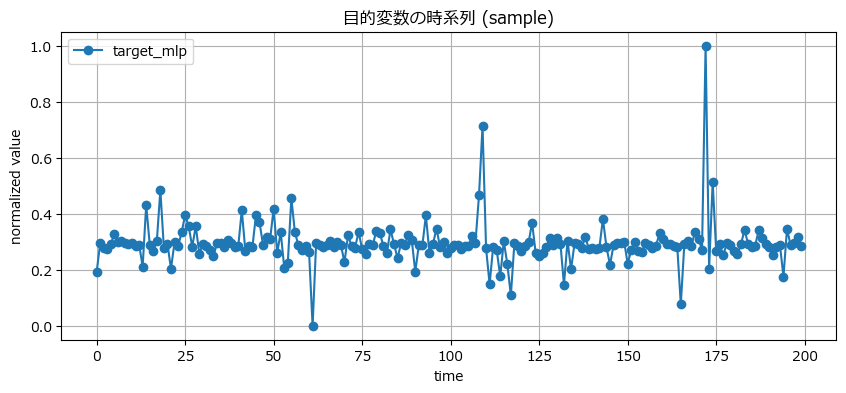

In [4]:
# 時系列プロット（サンプル）
plt.figure(figsize=(10, 4))
plt.plot(y.to_numpy(dtype=float), marker='o', label='target_mlp')
plt.title('目的変数の時系列 (sample)')
plt.xlabel('time')
plt.ylabel('normalized value')
plt.grid(True)
plt.legend()
plt.show()

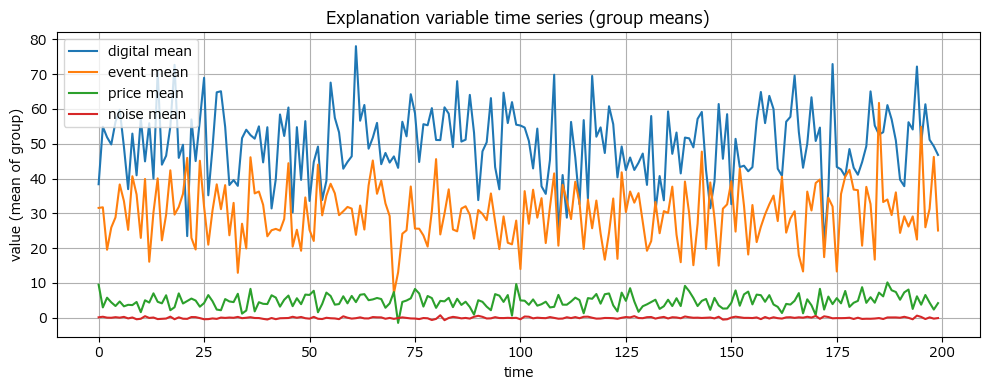

In [5]:
# 説明変数の時系列プロット（グループ平均）
groups = {
    'digital': [c for c in X.columns if c.startswith('digital_')],
    'event': [c for c in X.columns if c.startswith('event_')],
    'price': [c for c in X.columns if c.startswith('price_')],
    'noise': [c for c in X.columns if c.startswith('noise_')],
}
group_means = {k: X[v].mean(axis=1) for k, v in groups.items()}

plt.figure(figsize=(10, 4))
for name, series in group_means.items():
    plt.plot(series.to_numpy(dtype=float), label=f'{name} mean')
plt.title('Explanation variable time series (group means)')
plt.xlabel('time')
plt.ylabel('value (mean of group)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 前処理と交差検証設計
- 標準化（StandardScaler）を行い、パイプラインでCV内でfitする。
- 時系列性を考慮してシャッフルしないKFoldで評価を行う（本例ではKFold(n_splits=4, shuffle=False)）。

## テスト評価と比較
最良モデルでテストデータのRMSEを算出し、予測と真値をプロットします。

In [6]:
# モデル選定: MLP (非線形) と Ridge (線形) を比較

# MLP: solver='lbfgs' は小〜中規模のデータで安定して収束するため採用
pipeline_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(random_state=RANDOM_STATE, solver='lbfgs', max_iter=2000))
])
param_grid = {
    'mlp__hidden_layer_sizes': [(10,), (20,), (20, 10), (50,)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [1e-4, 1e-3, 1e-2]
}
search_mlp = GridSearchCV(pipeline_mlp, param_grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=1)
search_mlp.fit(X_train, y_train)

# Ridge baseline
pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=RANDOM_STATE))
])
param_grid_ridge = {'ridge__alpha': [1e-3, 1e-1, 1.0, 10.0]}
search_ridge = GridSearchCV(pipeline_ridge, param_grid_ridge, scoring='neg_mean_squared_error', cv=cv, n_jobs=1)
search_ridge.fit(X_train, y_train)



def _rmse(y_true, y_pred):
    """RMSE を計算する / Compute Root Mean Squared Error

    Args:
        y_true: 実測値 / true target values
        y_pred: 予測値 / predicted values
    Returns:
        float: RMSE
    """
    return sqrt(mean_squared_error(y_true, y_pred))

# CV / Test 評価
cv_rmse_mlp = np.sqrt(-search_mlp.best_score_)
cv_rmse_ridge = np.sqrt(-search_ridge.best_score_)

mlp_best = search_mlp.best_estimator_
ridge_best = search_ridge.best_estimator_

y_pred_mlp = mlp_best.predict(X_test)
y_pred_ridge = ridge_best.predict(X_test)

rmse_mlp = _rmse(y_test, y_pred_mlp)
rmse_ridge = _rmse(y_test, y_pred_ridge)

print('MLP best params:', search_mlp.best_params_)
print('Ridge best params:', search_ridge.best_params_)
print('CV RMSE MLP:', cv_rmse_mlp)
print('CV RMSE Ridge:', cv_rmse_ridge)
print('Test RMSE MLP:', rmse_mlp)
print('Test RMSE Ridge:', rmse_ridge)


MLP best params: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (20, 10)}
Ridge best params: {'ridge__alpha': 10.0}
CV RMSE MLP: 0.07339903963625599
CV RMSE Ridge: 0.0770577846814016
Test RMSE MLP: 0.10469149794963026
Test RMSE Ridge: 0.13807582767611204


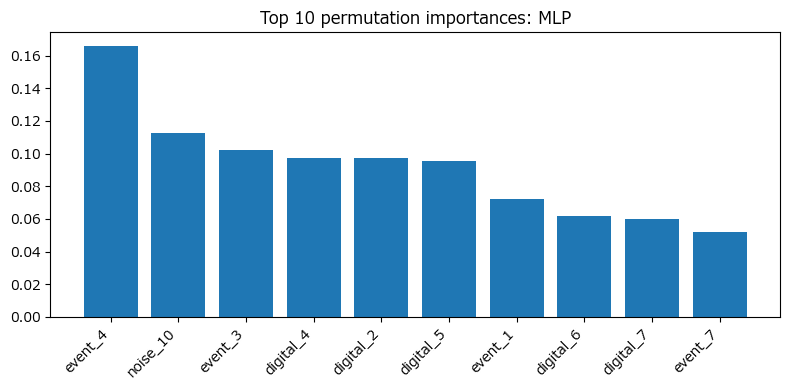

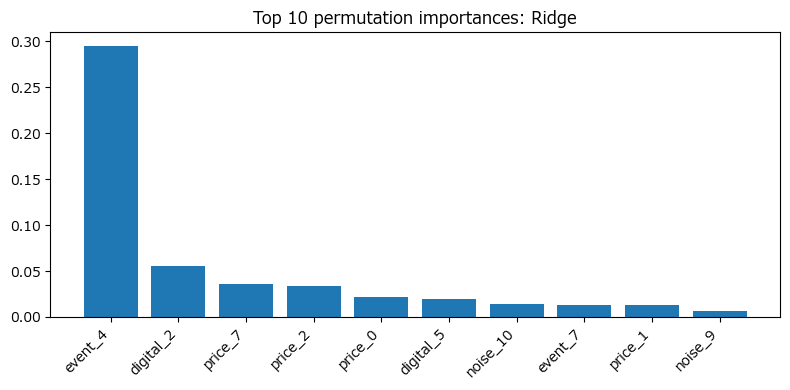

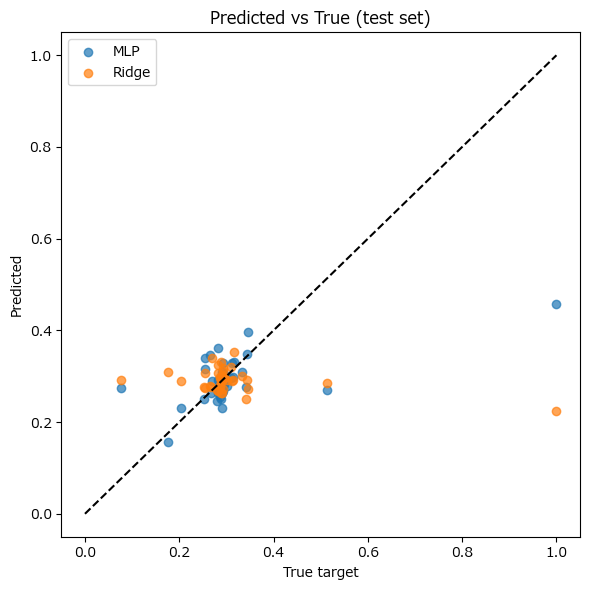

Note: MLP used solver="lbfgs" for more stable convergence on this sample size.


In [7]:
# Guard: ensure models are trained before evaluation
if 'mlp_best' not in globals() or 'ridge_best' not in globals():
    raise RuntimeError('Run the model selection cell before this cell (mlp_best/ridge_best missing).')

# 評価と解釈: 重要特徴量 (Permutation Importance) と予測プロット

# Permutation importance (test set)
res_mlp = permutation_importance(mlp_best, X_test, y_test, n_repeats=30, random_state=RANDOM_STATE, n_jobs=1)
res_ridge = permutation_importance(ridge_best, X_test, y_test, n_repeats=30, random_state=RANDOM_STATE, n_jobs=1)

# 上位10特徴量をプロット
def plot_top_importances(res, model_name: str, top_n: int = 10):
    """Plot top permutation importances.

    Args:
        res: permutation_importance の戻り値 (Bunch)
        model_name: モデル名 (文字列) / model name
        top_n: 上位何特徴量を表示するか / number of top features to plot

    描画は matplotlib を用いる。 / Uses matplotlib for plotting.
    """
    importances = res.importances_mean
    idx_sorted = np.argsort(importances)[::-1][:top_n]
    plt.figure(figsize=(8, 4))
    plt.bar(range(top_n), importances[idx_sorted])
    plt.xticks(range(top_n), X_test.columns[idx_sorted], rotation=45, ha='right')
    plt.title(f"Top {top_n} permutation importances: {model_name}")
    plt.tight_layout()
    plt.show()

plot_top_importances(res_mlp, 'MLP')
plot_top_importances(res_ridge, 'Ridge')

# 予測 vs 実測 (テスト)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_mlp, label='MLP', alpha=0.7)
plt.scatter(y_test, y_pred_ridge, label='Ridge', alpha=0.7)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('True target')
plt.ylabel('Predicted')
plt.legend()
plt.title('Predicted vs True (test set)')
plt.tight_layout()
plt.show()

# 収束・手順メモ
print('Note: MLP used solver="lbfgs" for more stable convergence on this sample size.')


## 結論と推奨事項
- 結果から、非線形性がある場合はMLPが改善する可能性があるが、小サンプルでは過学習に注意が必要です。\n- 交差検証・早期打ち切り・正則化・簡素なネットワーク構造を組み合わせて利用してください。\n- 解釈性の確保にはPermutation ImportanceやSHAP等を用いて、意思決定者に説明できる形に加工してください。